To judge the accuracy of Madden Ratings, two sets of models will be generated. The first sets of models will use NFL players' stats to try to predict their Madden rating. As Madden ratings are supposed to correspond to the skills and effectiveness of players, player stats should, in theory, corresspond to Madden ratings. The second set of models will use the extensive different values Madden gives out to rate specific attributes of players. These features will be used to predict the EPA of players, as this is the closest value I have available as a single marker for real player performance, as something like the PFF ratings are behind paywalls. The first set of code blocks involve importing packages, creating functions, and importing and cleaning the data.

In [82]:
#Importing needed packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [83]:
#Creates a function to calculate mean squared error
calc_MSE = lambda y, y_hat: np.mean((y - y_hat)**2)

In [84]:
#Import data from csv files
madden_df = pd.read_csv('madden_25_ratings.csv')
stats_off = pd.read_csv('player_stats_season.csv')
stats_def = pd.read_csv('player_stats_def_season.csv')
#Offense and defense dataframes from the last 3 seasons before Madden 25
stats_off = stats_off[stats_off['season'].isin([2021, 2022, 2023])]
stats_def = stats_def[stats_def['season'].isin([2021, 2022, 2023])]
#Remove offense/defense players that show up the defense/offense dataframes
stats_off = stats_off[~stats_off['position_group'].isin(['DB', 'LB', 'DL', 'SPEC'])]
stats_def = stats_def[~stats_def['position_group'].isin(['QB', 'OL', 'WR', 'RB', 'TE', 'SPEC'])]


As a test to the effectiveness of this strategy, I decided to start small, and only evaluate quarterback Madden ratings using 2023 data.

In [85]:
#Creates a dataframes with just 2023 data
stats_2023_off = stats_off[stats_off['season'].isin([2023])]
stats_2023_def = stats_def[stats_def['season'].isin([2023])]

In [86]:
#The Madden dataframe I use does not have a column with the full name of the player. So, before I can match the two dataframes together, I need to create a column with the full name of the player. This code was generated using Copilot.
madden_df['fullName'] = 0
for i in range(len(madden_df)):
    madden_df['fullName'][i] = madden_df['firstName'][i] + ' ' + madden_df['lastName'][i]

C:\Users\ogali\AppData\Local\Temp\ipykernel_14468\2632391723.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  madden_df['fullName'][i] = madden_df['firstName'][i] + ' ' + madden_df['lastName'][i]
C:\Users\ogali\AppData\Local\Temp\ipykerne

In [87]:
#Combines the Madden and Stats dataframes to get the player ratings and their real stats on the same dataframe.
stats_2023_off_madden = stats_2023_off.merge(madden_df, how='left', left_on=['player_display_name'], right_on=['fullName'])
stats_2023_def_madden = stats_2023_def.merge(madden_df, how='left', left_on=['player_display_name'], right_on=['fullName'])


In [88]:
#Checks if there are any people with the same name, generated with Copilot.
duplicate_names_off = stats_2023_off_madden[stats_2023_off_madden['season_type'] == 'REG']
duplicate_names_def = stats_2023_def_madden[stats_2023_def_madden['season_type'] == 'REG']
duplicate_names_off = duplicate_names_off['fullName'].value_counts()[duplicate_names_off['fullName'].value_counts() > 1]
duplicate_names_def = duplicate_names_def['fullName'].value_counts()[duplicate_names_def['fullName'].value_counts() > 1]
#Names of players with the same name (Josh Allen and Josh Allen or Lamar Jackson and Lamar Jackson) were renamed in the csv file.

In [89]:
#Dataframe of regular season qb stats
stats_2023_qb = stats_2023_off_madden[stats_2023_off_madden['position'] == 'QB']
stats_2023_qb_reg = stats_2023_qb[stats_2023_qb['season_type'] == 'REG']
stats_2023_qb_reg = stats_2023_qb_reg[['games', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'Age', 'Overall', 'fullName']]
stats_2023_qb_reg = stats_2023_qb_reg.dropna()

Now, a model can be created to predict the overall Madden ratings of players

In [90]:
#Creating features and targets
X = stats_2023_qb_reg[['games', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'Age']]
y = stats_2023_qb_reg['Overall']

model coefficients: [  0.23938276  -8.13180569  10.59193182 -14.63311781  -2.81683864
  -0.63268181  -0.22026592  -0.52705794  -0.59514874   2.70991945
  10.2345512    8.03925726   3.34072227   0.48110402   5.20743542
   1.69760595  -2.05692628  -0.43657426  -0.37513054  -2.05241622
   1.42911281   0.08379651], 70.85714285714286
R2_test = 0.25, R2_train = 0.81


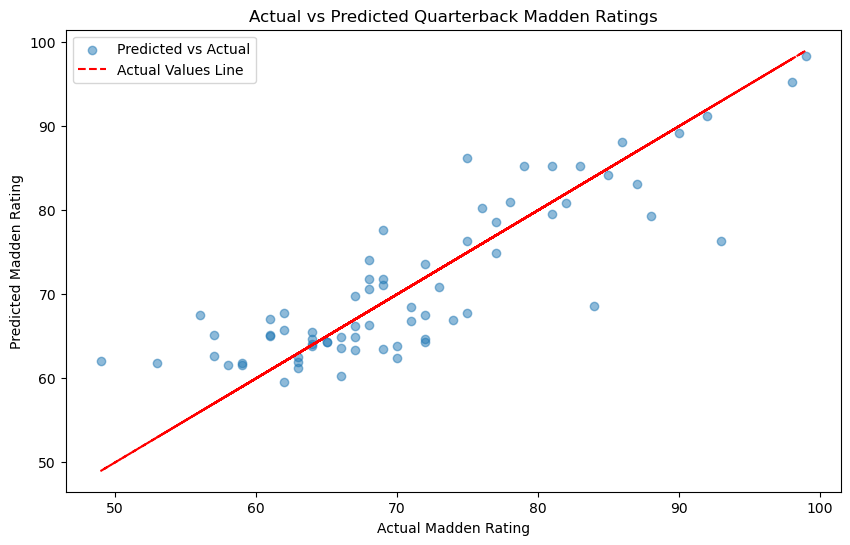

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize the features
ss = StandardScaler()
ss.fit(X_train)
X_scaled_train = ss.transform(X_train)
X_scaled_test = ss.transform(X_test)

# Fit the model
model_linreg = LinearRegression()
model_linreg.fit(X_scaled_train, y_train)

# Make predictions
y_pred_train = model_linreg.predict(X_scaled_train)
y_pred_test = model_linreg.predict(X_scaled_test)
y_pred = model_linreg.predict(ss.transform(X))

# Assess the model
R2_train = model_linreg.score(X_scaled_train, y_train)
R2_test = model_linreg.score(X_scaled_test, y_test)
print(f'model coefficients: {model_linreg.coef_}, {model_linreg.intercept_}')
print(f'R2_test = {R2_test:.2f}, R2_train = {R2_train:.2f}')


# Plotting the actual vs predicted values

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot(y, y, color='red', linestyle='--', label='Actual Values Line')
plt.xlabel('Actual Madden Rating')
plt.ylabel('Predicted Madden Rating')
plt.title('Actual vs Predicted Quarterback Madden Ratings')
plt.legend()
plt.show()

In [92]:
#Which quarterbacks were rated differently from their Madden rating?
qb_comparison_df = pd.DataFrame({
    'fullName': stats_2023_qb_reg['fullName'], 
    'Overall': stats_2023_qb_reg['Overall'],  
    'PredictedOverall': y_pred
})


The model was not awful in predicting Madden ratings, there seems to be some high residuals but in general, players with higher Madden ratings are predicted to have higher Madden ratings.

To visualize the distribution of Madden ratings for each position, I decided to create a segmented bar graph. While this does not provide information about the accuracy of Madden ratings, I found it an interesting way to visualize the spread in player ratings in the game. The players will be colored according to position, with the offense having cooler colors, the defense having warmer colors, and special teams being shades of gray.

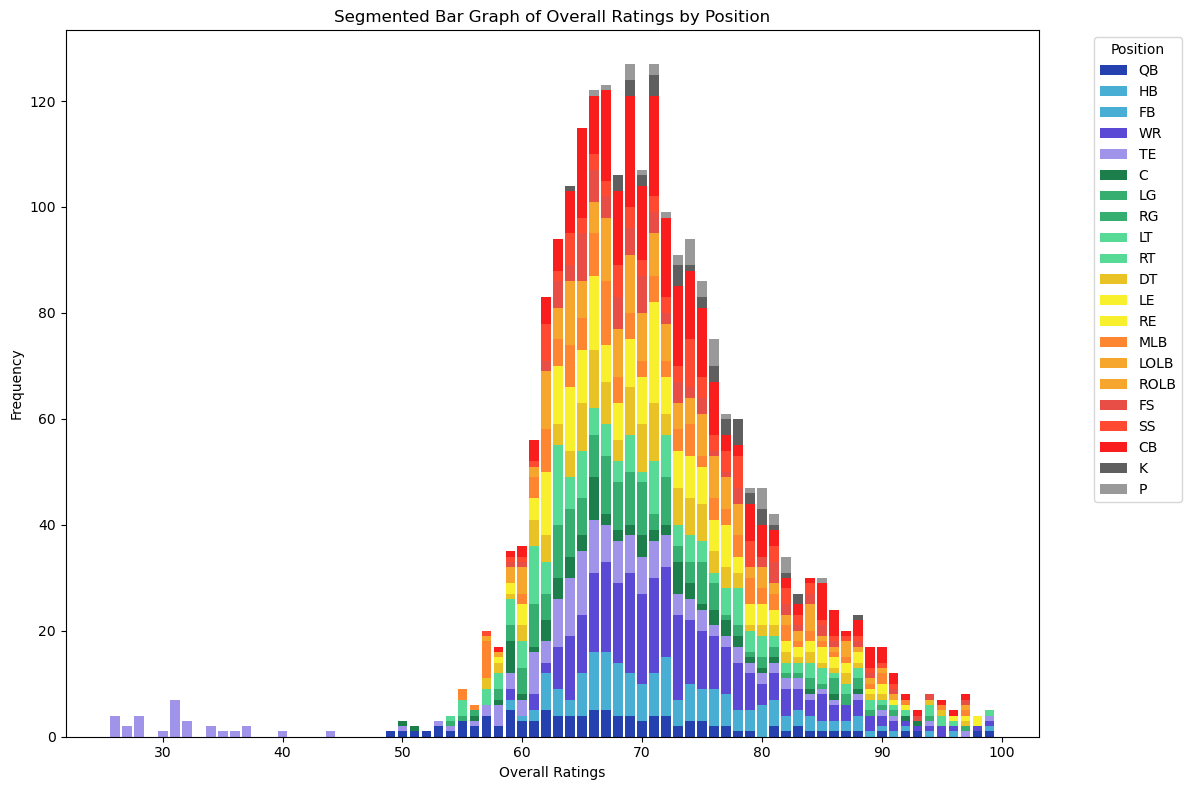

In [93]:
#Creates a dataframe to color code positions
color_df = madden_df[['Position', 'Overall']]
color_df['Position'].unique()

positions = ['QB', 'HB', 'FB', 'WR', 'TE', 'C', 'LG', 'RG', 'LT', 'RT', 'DT', 'LE', 'RE', 
             'MLB', 'LOLB', 'ROLB', 'FS', 'SS', 'CB', 'K', 'P']
hex_colors = [
    '#2540af', '#49aed4', '#49aed4', '#5a49d4', '#9f94e9', '#1c7e4b', '#35ae6f', 
    '#35ae6f', '#58da97', '#58da97', '#e9c325', '#f9f02d', '#f9f02d', '#ff8630', 
    '#f6a62d', '#f6a62d', '#e84e46', '#ff4930', '#f91d1d', '#5f5f5f', '#999999'
]

positions_color_df = pd.DataFrame({
    'Position': positions,
    'HexColor': hex_colors
})

color_df = color_df.merge(positions_color_df, how='left', left_on=['Position'], right_on=['Position'])
#Following here the code was generated using Copilot
# Define the desired order of positions
ordered_positions = ['QB', 'HB', 'FB', 'WR', 'TE', 'C', 'LG', 'RG', 'LT', 'RT', 
                     'DT', 'LE', 'RE', 'MLB', 'LOLB', 'ROLB', 'FS', 'SS', 'CB', 'K', 'P']

# Sort the color_df DataFrame based on the desired order
color_df['Position'] = pd.Categorical(color_df['Position'], categories=ordered_positions, ordered=True)
sorted_color_df = color_df.sort_values('Position')

# Get unique overall values and sort them
overall_values = sorted(sorted_color_df['Overall'].unique())

# Initialize a dictionary to store counts for each position at each overall value
position_counts = {position: [0] * len(overall_values) for position in ordered_positions}

# Populate the counts
for i, overall in enumerate(overall_values):
    for position in ordered_positions:
        position_counts[position][i] = len(sorted_color_df[(sorted_color_df['Overall'] == overall) & (sorted_color_df['Position'] == position)])

# Create a segmented bar graph
plt.figure(figsize=(12, 8))
bottom = np.zeros(len(overall_values))  # Initialize the bottom for stacking bars

for position in ordered_positions:
    plt.bar(
        overall_values, 
        position_counts[position], 
        bottom=bottom, 
        label=position, 
        color=sorted_color_df[sorted_color_df['Position'] == position]['HexColor'].iloc[0]
    )
    bottom += position_counts[position]  # Update the bottom for the next position

# Add labels, legend, and title
plt.xlabel('Overall Ratings')
plt.ylabel('Frequency')
plt.title('Segmented Bar Graph of Overall Ratings by Position')
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()


The distribution is not entirely normal, the right half of the curve extends for longer than the left half, and there are some tight end outliers with incredibly low Madden ratings.

After this initial exploration, I was ready to create models that predicted Madden ratings using stats from the 2021-2023 seasons. I decided to combine several positions in the model, as their stats do not differ significantly. The groupings I made were QB, RB (RB+FB), Receiving core (WR+TE), DB (CB, FS, SS), DL (RE, LE, DT) and LB (MLB, LOLB, and ROLB). The O-line was excluded from further exploration as there are not many statistical metrics specific to them to evaluate their talent in the data I have access to. Kickers and punters were also excluded, as again there are only a few metrics that corresspond to kicker skill. The following blocks of code will clean and sort data so they can be made into models. 

In [94]:
#Creates a dataframe with only regular+postseason data, rather than three separate rows for regular, post, and regular+post.
stats_off_total = stats_off[stats_off['season_type'] == 'REG+POST']
stats_def_total = stats_def[stats_def['season_type'] == 'REG+POST']

In [95]:
#This process combines the stats from the 2021, 2022, and 2023 seasons into one row for each player. Some stats are summed, and others are averaged, based on what I thought made the most sense. For example, passing yards was summed, whereas EPA was averaged between the 3 seasons.
stats_off_total = stats_off_total.groupby(['player_display_name', 'position', 'position_group']).agg(
    games=('games', 'sum'),
    completions=('completions', 'sum'),
    attempts=('attempts', 'sum'),
    passing_yards=('passing_yards', 'sum'),
    passing_tds=('passing_tds', 'sum'),
    interceptions=('interceptions', 'sum'),
    sack_yards=('sack_yards', 'sum'),
    sacks=('sacks', 'sum'),
    sack_fumbles=('sack_fumbles', 'sum'),
    sack_fumbles_lost=('sack_fumbles_lost', 'sum'),
    passing_air_yards=('passing_air_yards', 'sum'),
    passing_yards_after_catch=('passing_yards_after_catch', 'sum'),
    passing_first_downs=('passing_first_downs', 'sum'),
    passing_epa=('passing_epa', 'mean'),
    pacr=('pacr', 'mean'),
    dakota=('dakota', 'mean'),
    carries=('carries', 'sum'),
    rushing_yards=('rushing_yards', 'sum'),
    rushing_tds=('rushing_tds', 'sum'),
    rushing_fumbles=('rushing_fumbles', 'sum'),
    rushing_fumbles_lost=('rushing_fumbles_lost', 'sum'),
    rushing_first_downs=('rushing_first_downs', 'sum'),
    rushing_epa=('rushing_epa', 'mean'),
    receptions=('receptions', 'sum'),
    targets=('targets', 'sum'),
    receiving_yards=('receiving_yards', 'sum'),
    receiving_tds=('receiving_tds', 'sum'),
    receiving_fumbles=('receiving_fumbles', 'sum'),
    receiving_fumbles_lost=('receiving_fumbles_lost', 'sum'),
    receiving_air_yards=('receiving_air_yards', 'sum'),
    receiving_yards_after_catch=('receiving_yards_after_catch', 'sum'),
    receiving_first_downs=('receiving_first_downs', 'sum'),
    receiving_epa=('receiving_epa', 'mean'),
    target_share=('target_share', 'sum'),
    air_yards_share=('air_yards_share', 'sum'),
    wopr=('wopr', 'mean'),
    racr=('racr', 'mean'),
).reset_index()
stats_def_total = stats_def_total.groupby(['player_display_name', 'position', 'position_group']).agg(
    games=('games', 'sum'),
    def_tackles=('def_tackles', 'sum'),
    def_tackles_solo=('def_tackles_solo', 'sum'),
    def_tackles_with_assist=('def_tackles_with_assist', 'sum'),
    def_tackle_assists=('def_tackle_assists', 'sum'),
    def_tackles_for_loss=('def_tackles_for_loss', 'sum'),
    def_tackles_for_loss_yards=('def_tackles_for_loss_yards', 'sum'),
    def_fumbles_forced=('def_fumbles_forced', 'sum'),
    def_sacks=('def_sacks', 'sum'),
    def_sack_yards=('def_sack_yards', 'sum'),
    def_qb_hits=('def_qb_hits', 'sum'),
    def_interceptions=('def_interceptions', 'sum'),
    def_interception_yards=('def_interception_yards', 'sum'),
    def_passes_defended=('def_pass_defended', 'sum'),
    def_tds=('def_tds', 'sum'),
    def_fumbles=('def_fumbles', 'sum'),
    def_fumble_recovery_own=('def_fumble_recovery_own', 'sum'),
    def_fumble_recovery_yards_own=('def_fumble_recovery_yards_own', 'sum'),
    def_fumble_recovery_opp=('def_fumble_recovery_opp', 'sum'),
    def_fumble_recovery_yards_opp=('def_fumble_recovery_yards_opp', 'sum'),
    def_safety=('def_safety', 'sum'),
    def_penalty=('def_penalty', 'sum'),
    def_penalty_yards=('def_penalty_yards', 'sum'),
    ).reset_index()

In [96]:
#Combines the Madden and Stats dataframes to add the Madden ratings to the stats dataframes.
stats_off_total = stats_off_total.merge(madden_df, how='left', left_on=['player_display_name'], right_on=['fullName'])
stats_def_total = stats_def_total.merge(madden_df, how='left', left_on=['player_display_name'], right_on=['fullName'])



In [97]:
#Some players with stats but who did not have Madden ratings were removed by filling NaNs with 0, and then dropping any player with 0 in the Overall column.
stats_off_total['Overall'] = stats_off_total['Overall'].fillna(0)
stats_def_total['Overall'] = stats_def_total['Overall'].fillna(0)
stats_off_total = stats_off_total[stats_off_total['Overall'] != 0]
stats_def_total = stats_def_total[stats_def_total['Overall'] != 0]

In [98]:
#Separates dataframes into specific ones for quarterback, receiving core, running backs, defensive backs, and defensive linemen. This will allow more accurate predictions to be made, as these position groups will have more similar stats to each other than an unsegmented list of players.
stats_qb = stats_off_total[stats_off_total['position'] == 'QB']
stats_receiver = stats_off_total[stats_off_total['position'].isin(['WR', 'TE'])]
stats_rb = stats_off_total[stats_off_total['position_group'] == 'RB']
stats_db = stats_def_total[stats_def_total['position_group'] == 'DB']
stats_dl = stats_def_total[stats_def_total['position_group']== 'DL']
stats_lb = stats_def_total[stats_def_total['position_group']== 'LB']


In [99]:
#Some players that did not have values for certain features had their NaNs filled with 0. This should not cause predictive errors as all of these stats should be 0, rather than NaN.
stats_receiver = stats_receiver.fillna(0)
stats_rb = stats_rb.fillna(0)
stats_db = stats_db.fillna(0)
stats_dl = stats_dl.fillna(0)
stats_lb = stats_lb.fillna(0)

Finally, we are ready to make models. The next code blocks will generate linear regression lines to predict the Madden ratings of different position groups based on their stats in the 2021, 2022, and 2023 NFL seasons.

R2_test = 0.71, R2_train = 0.83


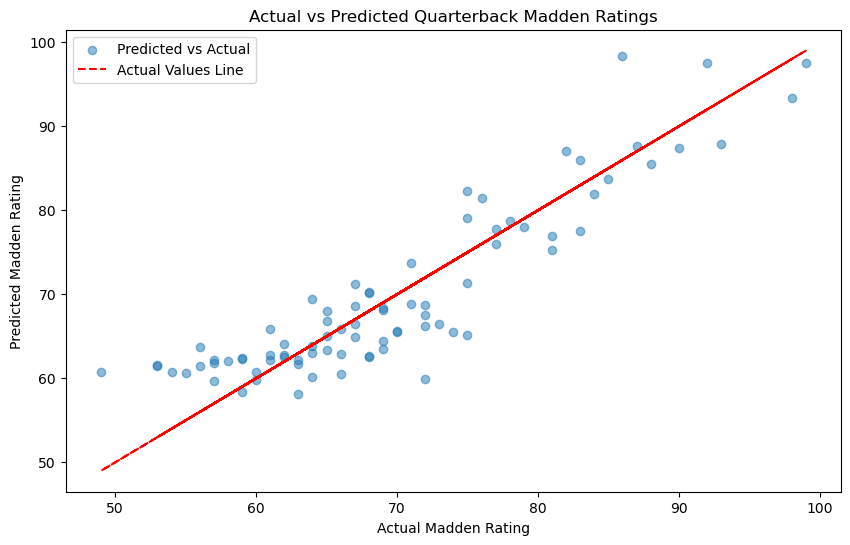

In [100]:
#Quarterbacks
#Creating features and targets
X = stats_qb[['games', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'Age']]
y = stats_qb['Overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize the features
ss = StandardScaler()
ss.fit(X_train)
X_scaled_train = ss.transform(X_train)
X_scaled_test = ss.transform(X_test)

# Fit the model
model_linreg = LinearRegression()
model_linreg.fit(X_scaled_train, y_train)

# Make predictions
y_pred_train = model_linreg.predict(X_scaled_train)
y_pred_test = model_linreg.predict(X_scaled_test)
y_pred = model_linreg.predict(ss.transform(X))

# Assess the model
R2_train = model_linreg.score(X_scaled_train, y_train)
R2_test = model_linreg.score(X_scaled_test, y_test)
print(f'R2_test = {R2_test:.2f}, R2_train = {R2_train:.2f}')


# Plotting the actual vs predicted values

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot(y, y, color='red', linestyle='--', label='Actual Values Line')
plt.xlabel('Actual Madden Rating')
plt.ylabel('Predicted Madden Rating')
plt.title('Actual vs Predicted Quarterback Madden Ratings')
plt.legend()
plt.show()

In [101]:
#Creates a dataframe with the actual and predicted values for the quarterbacks.
qb_comparison_df = pd.DataFrame({
    'fullName': stats_qb['fullName'], 
    'Overall': stats_qb['Overall'],  
    'PredictedOverall': y_pred,
    'position_group': stats_qb['position_group']
})
#Calculates MSE
MSE_qb = calc_MSE(y, y_pred)

R2_test = 0.86, R2_train = 0.88


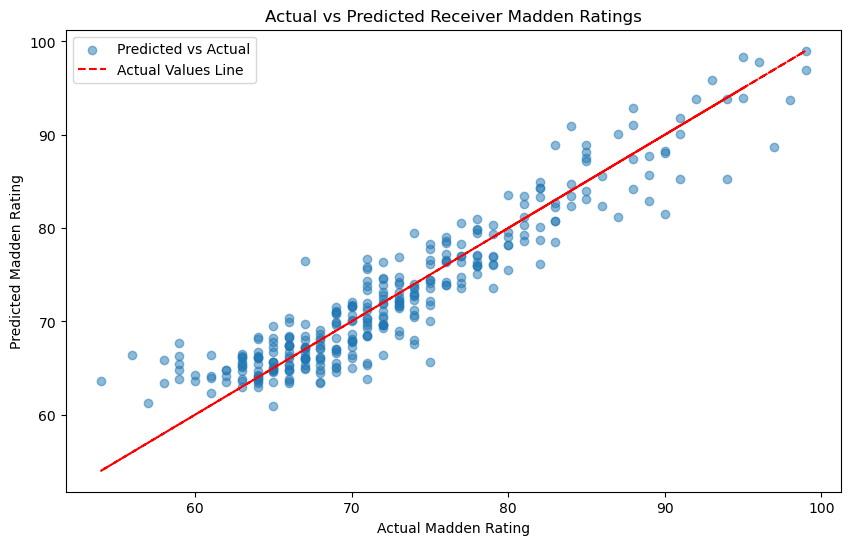

In [102]:
#Receiving Core
#Creating features and targets
X = stats_receiver[['games', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_epa', 'target_share', 'air_yards_share', 'wopr', 'racr', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'Age']]
y = stats_receiver['Overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize the features
ss = StandardScaler()
ss.fit(X_train)
X_scaled_train = ss.transform(X_train)
X_scaled_test = ss.transform(X_test)

# Fit the model
model_linreg = LinearRegression()
model_linreg.fit(X_scaled_train, y_train)

# Make predictions
y_pred_train = model_linreg.predict(X_scaled_train)
y_pred_test = model_linreg.predict(X_scaled_test)
y_pred = model_linreg.predict(ss.transform(X))

# Assess the model
R2_train = model_linreg.score(X_scaled_train, y_train)
R2_test = model_linreg.score(X_scaled_test, y_test)
print(f'R2_test = {R2_test:.2f}, R2_train = {R2_train:.2f}')


# Plotting the actual vs predicted values

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot(y, y, color='red', linestyle='--', label='Actual Values Line')
plt.xlabel('Actual Madden Rating')
plt.ylabel('Predicted Madden Rating')
plt.title('Actual vs Predicted Receiver Madden Ratings')
plt.legend()
plt.show()

In [103]:
#Creates a dataframe with the actual and predicted values for the receiving core.
receiver_comparison_df = pd.DataFrame({
    'fullName': stats_receiver['fullName'], 
    'Overall': stats_receiver['Overall'],  
    'PredictedOverall': y_pred,
    'position_group': stats_receiver['position_group']
})
#Calculates MSE
MSE_receiver = calc_MSE(y, y_pred)


R2_test = 0.71, R2_train = 0.76


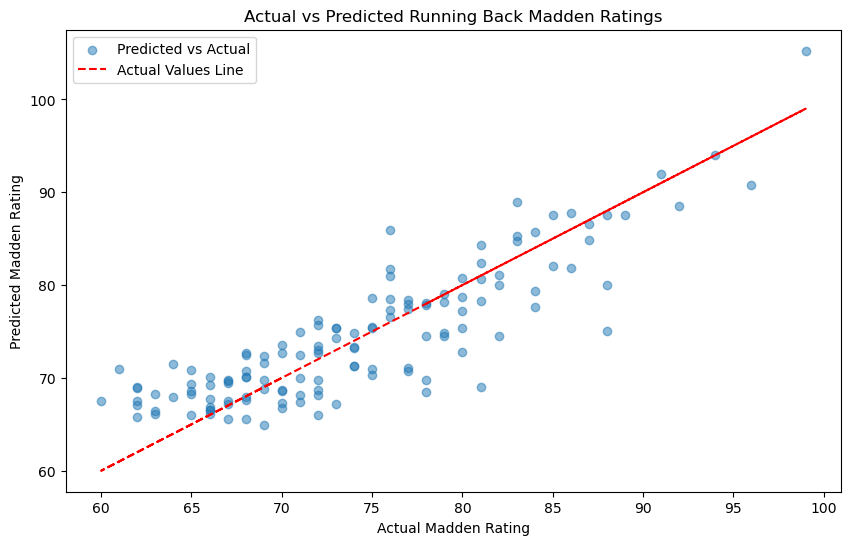

In [104]:
#Running Backs
#Creating features and targets
X = stats_rb[['games', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_epa', 'target_share', 'air_yards_share', 'wopr', 'racr', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'Age']]
y = stats_rb['Overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize the features
ss = StandardScaler()
ss.fit(X_train)
X_scaled_train = ss.transform(X_train)
X_scaled_test = ss.transform(X_test)

# Fit the model
model_linreg = LinearRegression()
model_linreg.fit(X_scaled_train, y_train)

# Make predictions
y_pred_train = model_linreg.predict(X_scaled_train)
y_pred_test = model_linreg.predict(X_scaled_test)
y_pred = model_linreg.predict(ss.transform(X))

# Assess the model
R2_train = model_linreg.score(X_scaled_train, y_train)
R2_test = model_linreg.score(X_scaled_test, y_test)
print(f'R2_test = {R2_test:.2f}, R2_train = {R2_train:.2f}')


# Plotting the actual vs predicted values

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot(y, y, color='red', linestyle='--', label='Actual Values Line')
plt.xlabel('Actual Madden Rating')
plt.ylabel('Predicted Madden Rating')
plt.title('Actual vs Predicted Running Back Madden Ratings')
plt.legend()
plt.show()

In [105]:
#Creates a dataframe with the actual and predicted values for the running backs.
rb_comparison_df = pd.DataFrame({
    'fullName': stats_rb['fullName'], 
    'Overall': stats_rb['Overall'],  
    'PredictedOverall': y_pred,
    'position_group': stats_rb['position_group']
})
#Calculates MSE
MSE_rb = calc_MSE(y, y_pred)


R2_test = 0.60, R2_train = 0.57


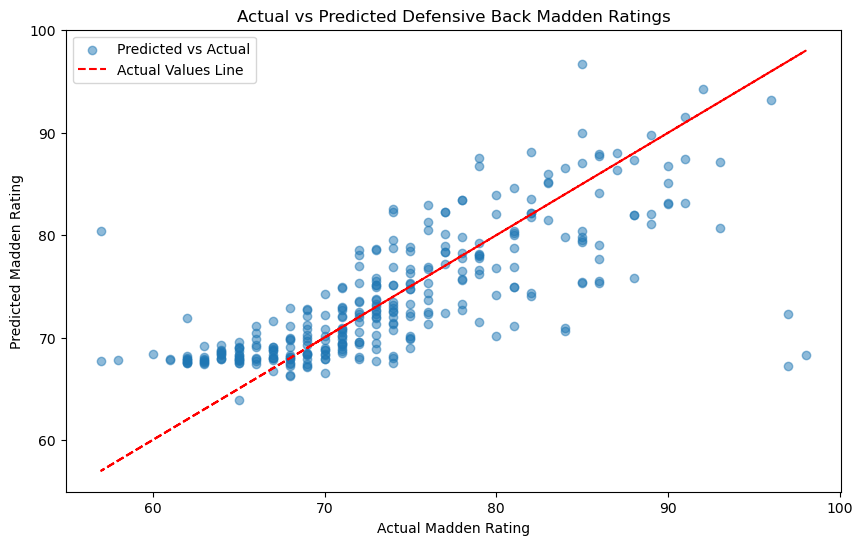

In [106]:
#Defensive Backs
#Creating features and targets
X = stats_db[['games', 'def_tackles', 'def_tackles_solo', 'def_tackles_with_assist', 'def_tackle_assists', 'def_tackles_for_loss', 'def_tackles_for_loss_yards', 'def_fumbles_forced', 'def_sacks', 'def_sack_yards', 'def_qb_hits', 'def_interceptions', 'def_interception_yards', 'def_passes_defended', 'def_fumbles', 'def_fumble_recovery_own', 'def_fumble_recovery_yards_own', 'def_fumble_recovery_yards_opp', 'def_safety', 'def_penalty', 'def_penalty_yards', 'Age']]
y = stats_db['Overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize the features
ss = StandardScaler()
ss.fit(X_train)
X_scaled_train = ss.transform(X_train)
X_scaled_test = ss.transform(X_test)

# Fit the model
model_linreg = LinearRegression()
model_linreg.fit(X_scaled_train, y_train)

# Make predictions
y_pred_train = model_linreg.predict(X_scaled_train)
y_pred_test = model_linreg.predict(X_scaled_test)
y_pred = model_linreg.predict(ss.transform(X))

# Assess the model
R2_train = model_linreg.score(X_scaled_train, y_train)
R2_test = model_linreg.score(X_scaled_test, y_test)
print(f'R2_test = {R2_test:.2f}, R2_train = {R2_train:.2f}')


# Plotting the actual vs predicted values

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot(y, y, color='red', linestyle='--', label='Actual Values Line')
plt.xlabel('Actual Madden Rating')
plt.ylabel('Predicted Madden Rating')
plt.title('Actual vs Predicted Defensive Back Madden Ratings')
plt.legend()
plt.show()

In [107]:
#Creates a dataframe with the actual and predicted values for the defensive backs.
db_comparison_df = pd.DataFrame({
    'fullName': stats_db['fullName'], 
    'Overall': stats_db['Overall'],  
    'PredictedOverall': y_pred,
    'position_group': stats_db['position_group']
})
#Calculates MSE
MSE_db = calc_MSE(y, y_pred)


R2_test = -0.15, R2_train = 0.66


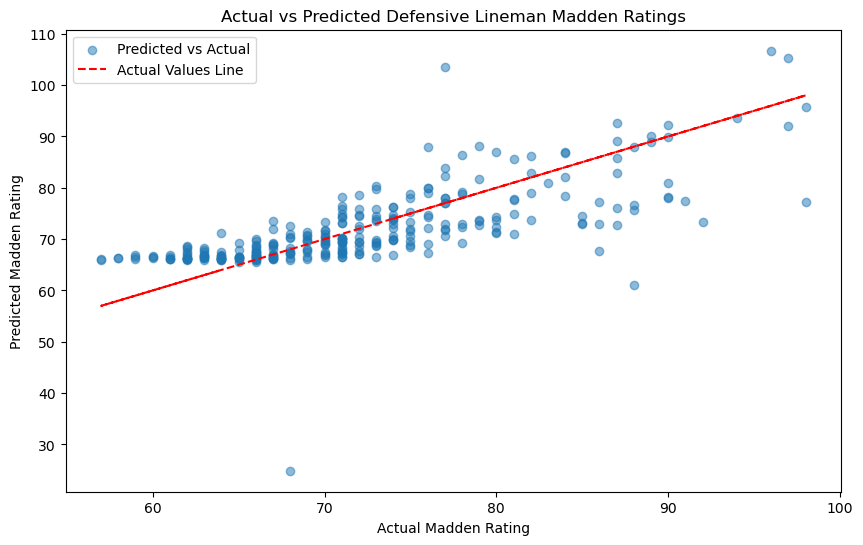

In [108]:
#Defensive Linemen
#Creating features and targets
X = stats_dl[['games', 'def_tackles', 'def_tackles_solo', 'def_tackles_with_assist', 'def_tackle_assists', 'def_tackles_for_loss', 'def_tackles_for_loss_yards', 'def_fumbles_forced', 'def_sacks', 'def_sack_yards', 'def_qb_hits', 'def_interceptions', 'def_interception_yards', 'def_passes_defended', 'def_fumbles', 'def_fumble_recovery_own', 'def_fumble_recovery_yards_own', 'def_fumble_recovery_yards_opp', 'def_safety', 'def_penalty', 'def_penalty_yards', 'Age']]
y = stats_dl['Overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize the features
ss = StandardScaler()
ss.fit(X_train)
X_scaled_train = ss.transform(X_train)
X_scaled_test = ss.transform(X_test)

# Fit the model
model_linreg = LinearRegression()
model_linreg.fit(X_scaled_train, y_train)

# Make predictions
y_pred_train = model_linreg.predict(X_scaled_train)
y_pred_test = model_linreg.predict(X_scaled_test)
y_pred = model_linreg.predict(ss.transform(X))

# Assess the model
R2_train = model_linreg.score(X_scaled_train, y_train)
R2_test = model_linreg.score(X_scaled_test, y_test)
print(f'R2_test = {R2_test:.2f}, R2_train = {R2_train:.2f}')


# Plotting the actual vs predicted values

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot(y, y, color='red', linestyle='--', label='Actual Values Line')
plt.xlabel('Actual Madden Rating')
plt.ylabel('Predicted Madden Rating')
plt.title('Actual vs Predicted Defensive Lineman Madden Ratings')
plt.legend()
plt.show()

In [109]:
#Creates a dataframe with the actual and predicted values for the defensive linemen.
dl_comparison_df = pd.DataFrame({
    'fullName': stats_dl['fullName'], 
    'Overall': stats_dl['Overall'],  
    'PredictedOverall': y_pred,
    'position_group': stats_dl['position_group']
})
#Calculates MSE
MSE_dl = calc_MSE(y, y_pred)

R2_test = 0.65, R2_train = 0.75


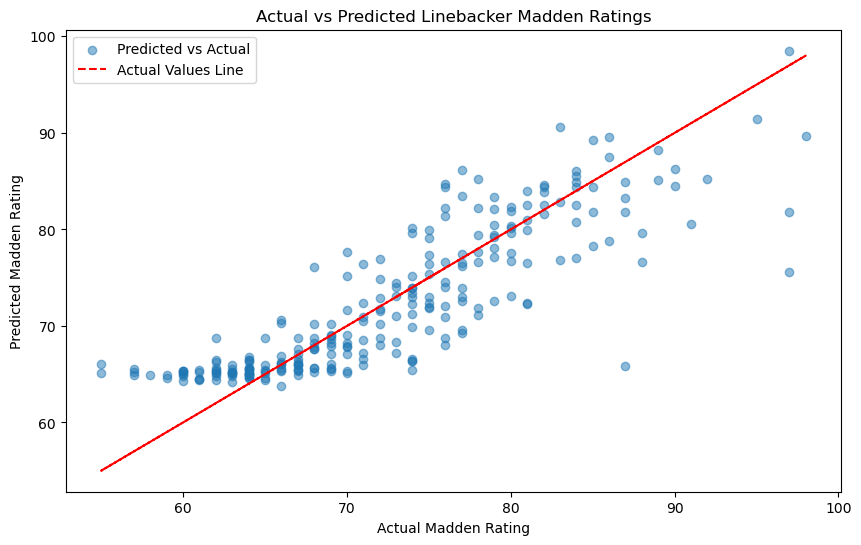

In [110]:
#Linebackers
#Creating features and targets
X = stats_lb[['games', 'def_tackles', 'def_tackles_solo', 'def_tackles_with_assist', 'def_tackle_assists', 'def_tackles_for_loss', 'def_tackles_for_loss_yards', 'def_fumbles_forced', 'def_sacks', 'def_sack_yards', 'def_qb_hits', 'def_interceptions', 'def_interception_yards', 'def_passes_defended', 'def_fumbles', 'def_fumble_recovery_own', 'def_fumble_recovery_yards_own', 'def_fumble_recovery_yards_opp', 'def_safety', 'def_penalty', 'def_penalty_yards', 'Age']]
y = stats_lb['Overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize the features
ss = StandardScaler()
ss.fit(X_train)
X_scaled_train = ss.transform(X_train)
X_scaled_test = ss.transform(X_test)

# Fit the model
model_linreg = LinearRegression()
model_linreg.fit(X_scaled_train, y_train)

# Make predictions
y_pred_train = model_linreg.predict(X_scaled_train)
y_pred_test = model_linreg.predict(X_scaled_test)
y_pred = model_linreg.predict(ss.transform(X))

# Assess the model
R2_train = model_linreg.score(X_scaled_train, y_train)
R2_test = model_linreg.score(X_scaled_test, y_test)
print(f'R2_test = {R2_test:.2f}, R2_train = {R2_train:.2f}')


# Plotting the actual vs predicted values

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot(y, y, color='red', linestyle='--', label='Actual Values Line')
plt.xlabel('Actual Madden Rating')
plt.ylabel('Predicted Madden Rating')
plt.title('Actual vs Predicted Linebacker Madden Ratings')
plt.legend()
plt.show()

In [111]:
#Creates a dataframe with the actual and predicted values for the defensive linemen.
lb_comparison_df = pd.DataFrame({
    'fullName': stats_lb['fullName'], 
    'Overall': stats_lb['Overall'],  
    'PredictedOverall': y_pred,
    'position_group': stats_lb['position_group']
})
#Calculates MSE
MSE_dl = calc_MSE(y, y_pred)

The models were best at predicting receiver and linebacker Madden ratings. This may show that Madden ratings are more accurate reflections of receiver and linebacker stats than the other position groups. The next set of code blocks will generate a plot of the residuals, to see which position groups have greater differences between their predicted and actual Madden ratings.

In [112]:
#Combines the dataframes of predicted Madden ratings into one dataframe
rating_df = pd.concat([qb_comparison_df, receiver_comparison_df, rb_comparison_df, db_comparison_df, dl_comparison_df, lb_comparison_df], ignore_index=True)

In [113]:
#Creates a dataframe to color code the position groups
position_groups = ['QB', 'RB', 'WR', 'TE', 'DB', 'DL', 'LB']
hex_colors = [
    '#2540af', '#3294a8', '#32a840', '#32a840', '#b81f1f', '#f2e933', '#ff9808'
]

position_groups_color_df = pd.DataFrame({
    'Position_group': position_groups,
    'HexColor': hex_colors
})

In [114]:
#Adds a column to the ratings dataframe to calculate the residuals
rating_df['residual'] = rating_df['Overall'] - rating_df['PredictedOverall']
#Adds a column to the ratings dataframe to color code the values based on their position group.
rating_df = rating_df.merge(position_groups_color_df, how='left', left_on=['position_group'], right_on=['Position_group'])
rating_df = rating_df.drop(columns=['Position_group'])

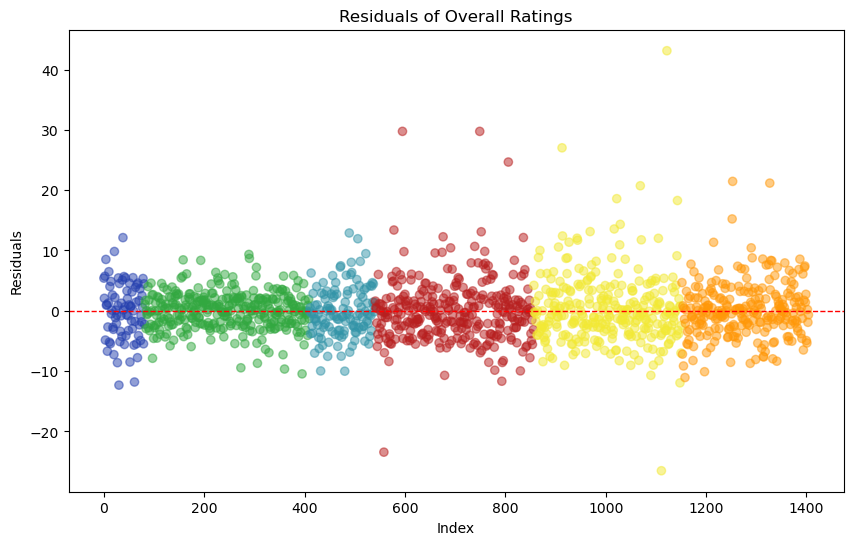

In [115]:
# Plot the residuals, made with Copilot
plt.figure(figsize=(10, 6))
plt.scatter(rating_df.index, rating_df['residual'], c=rating_df['HexColor'], alpha=0.5)

# Add labels and title
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residuals of Overall Ratings')
plt.show()

LEGEND:
QB = Blue, WR/TE = Green, RB = Light Blue, DB = Red, DL = Yellow, LB = Orange

WR/TE appears to have the smallest residuals, while the defensive players have large outliers.

Next, I will generate models that predict offensive player EPA based on the many different ratings Madden assigns players. This will allow me to compare how real stats predict Madden ratings with how Madden ratings can predict player performance.

In [116]:
#Creates a list of the features to be used to predict EPA based on Madden ratings.
madden_stats = ['Age','Overall','stats/acceleration/value','stats/acceleration/diff','stats/agility/value','stats/agility/diff','stats/jumping/value','stats/jumping/diff','stats/stamina/value','stats/stamina/diff','stats/strength/value','stats/strength/diff','stats/awareness/value','stats/awareness/diff','stats/bCVision/value','stats/bCVision/diff','stats/blockShedding/value','stats/blockShedding/diff','stats/breakSack/value','stats/breakSack/diff','stats/breakTackle/value','stats/breakTackle/diff','stats/carrying/value','stats/carrying/diff','stats/catchInTraffic/value','stats/catchInTraffic/diff','stats/catching/value','stats/catching/diff','stats/changeOfDirection/value','stats/changeOfDirection/diff','stats/deepRouteRunning/value','stats/deepRouteRunning/diff','stats/finesseMoves/value','stats/finesseMoves/diff','stats/hitPower/value','stats/hitPower/diff','stats/impactBlocking/value','stats/impactBlocking/diff','stats/injury/value','stats/injury/diff','stats/jukeMove/value','stats/jukeMove/diff','stats/kickAccuracy/value','stats/kickAccuracy/diff','stats/kickPower/value','stats/kickPower/diff','stats/kickReturn/value','stats/kickReturn/diff','stats/leadBlock/value','stats/leadBlock/diff','stats/manCoverage/value','stats/manCoverage/diff','stats/mediumRouteRunning/value','stats/mediumRouteRunning/diff','stats/overall/value','stats/overall/diff','stats/passBlock/value','stats/passBlock/diff','stats/passBlockFinesse/value','stats/passBlockFinesse/diff','stats/passBlockPower/value','stats/passBlockPower/diff','stats/playAction/value','stats/playAction/diff','stats/playRecognition/value','stats/playRecognition/diff','stats/powerMoves/value','stats/powerMoves/diff','stats/press/value','stats/press/diff','stats/pursuit/value','stats/pursuit/diff','stats/release/value','stats/release/diff','stats/runBlock/value','stats/runBlock/diff','stats/runBlockFinesse/value','stats/runBlockFinesse/diff','stats/runBlockPower/value','stats/runBlockPower/diff','stats/runningStyle/diff','stats/shortRouteRunning/value','stats/shortRouteRunning/diff','stats/spectacularCatch/value','stats/spectacularCatch/diff','stats/speed/value','stats/speed/diff','stats/spinMove/value','stats/spinMove/diff','stats/stiffArm/value','stats/stiffArm/diff','stats/tackle/value','stats/tackle/diff','stats/throwAccuracyDeep/value','stats/throwAccuracyDeep/diff','stats/throwAccuracyMid/value','stats/throwAccuracyMid/diff','stats/throwAccuracyShort/value','stats/throwAccuracyShort/diff','stats/throwOnTheRun/value','stats/throwOnTheRun/diff','stats/throwPower/value','stats/throwPower/diff','stats/throwUnderPressure/value','stats/throwUnderPressure/diff','stats/toughness/value','stats/toughness/diff','stats/trucking/value','stats/trucking/diff','stats/zoneCoverage/value','stats/zoneCoverage/diff']

R2_test = -76.99, R2_train = 0.97


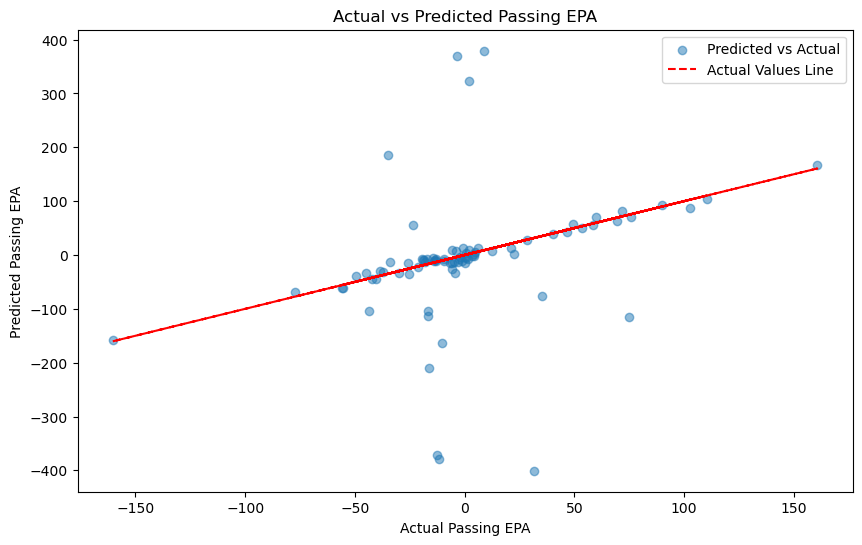

In [117]:
#Quarterbacks
#Creating features and targets
X = stats_qb[madden_stats]
y = stats_qb['passing_epa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize the features
ss = StandardScaler()
ss.fit(X_train)
X_scaled_train = ss.transform(X_train)
X_scaled_test = ss.transform(X_test)

# Fit the model
model_linreg = LinearRegression()
model_linreg.fit(X_scaled_train, y_train)

# Make predictions
y_pred_train = model_linreg.predict(X_scaled_train)
y_pred_test = model_linreg.predict(X_scaled_test)
y_pred = model_linreg.predict(ss.transform(X))

# Assess the model
R2_train = model_linreg.score(X_scaled_train, y_train)
R2_test = model_linreg.score(X_scaled_test, y_test)
print(f'R2_test = {R2_test:.2f}, R2_train = {R2_train:.2f}')


# Plotting the actual vs predicted values

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot(y, y, color='red', linestyle='--', label='Actual Values Line')
plt.xlabel('Actual Passing EPA')
plt.ylabel('Predicted Passing EPA')
plt.title('Actual vs Predicted Passing EPA')
plt.legend()
plt.show()
#Creates a dataframe with the actual and predicted EPAs for quarterbacks.
qb_epa_comparison_df = pd.DataFrame({
    'fullName': stats_qb['fullName'], 
    'Epa': stats_qb['passing_epa'],  
    'PredictedEpa': y_pred,
    'position_group': stats_qb['position_group']
})
#Calculates MSE
MSE_qb = calc_MSE(y, y_pred)

R2_test = -5.30, R2_train = -0.12


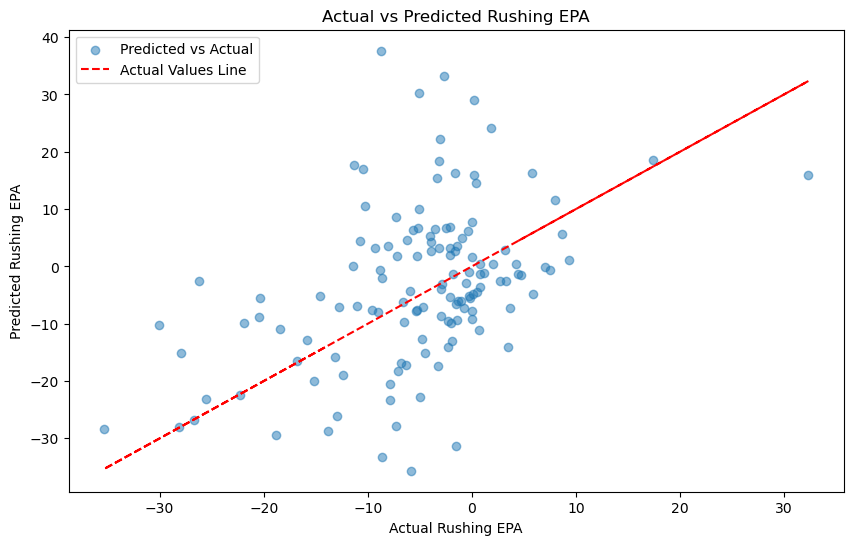

In [118]:
#Running Backs
#Creating features and targets
X = stats_rb[madden_stats]
y = stats_rb['rushing_epa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize the features
ss = StandardScaler()
ss.fit(X_train)
X_scaled_train = ss.transform(X_train)
X_scaled_test = ss.transform(X_test)

# Fit the model
model_linreg = LinearRegression()
model_linreg.fit(X_scaled_train, y_train)

# Make predictions
y_pred_train = model_linreg.predict(X_scaled_train)
y_pred_test = model_linreg.predict(X_scaled_test)
y_pred = model_linreg.predict(ss.transform(X))

# Assess the model
R2_train = model_linreg.score(X_scaled_train, y_train)
R2_test = model_linreg.score(X_scaled_test, y_test)
print(f'R2_test = {R2_test:.2f}, R2_train = {R2_train:.2f}')


# Plotting the actual vs predicted values

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot(y, y, color='red', linestyle='--', label='Actual Values Line')
plt.xlabel('Actual Rushing EPA')
plt.ylabel('Predicted Rushing EPA')
plt.title('Actual vs Predicted Rushing EPA')
plt.legend()
plt.show()
#Creates a dataframe with the actual and predicted EPAs for running backs.
rb_epa_comparison_df = pd.DataFrame({
    'fullName': stats_rb['fullName'], 
    'Epa': stats_rb['rushing_epa'],  
    'PredictedEpa': y_pred,
    'position_group': stats_rb['position_group']
})
#Calculates MSE
MSE_qb = calc_MSE(y, y_pred)

R2_test = 0.56, R2_train = 0.72


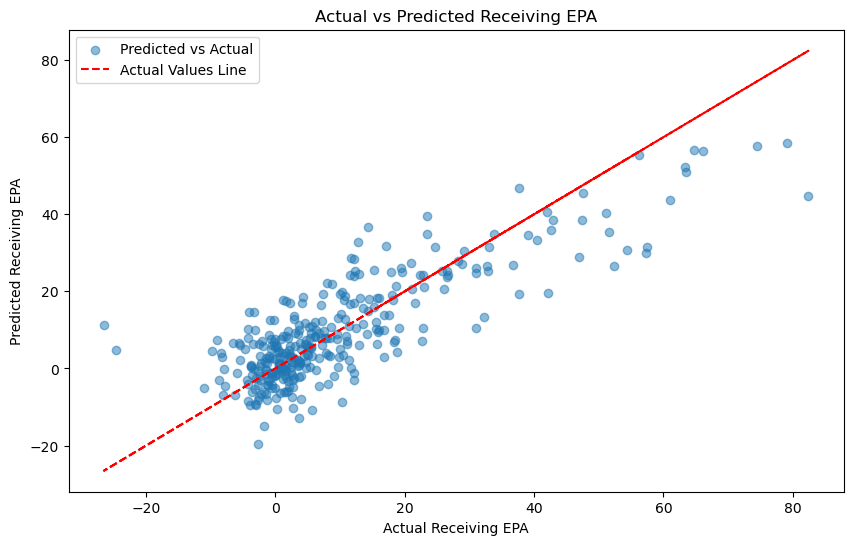

In [119]:
#Receiving Core
#Creating features and targets
X = stats_receiver[madden_stats]
y = stats_receiver['receiving_epa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize the features
ss = StandardScaler()
ss.fit(X_train)
X_scaled_train = ss.transform(X_train)
X_scaled_test = ss.transform(X_test)

# Fit the model
model_linreg = LinearRegression()
model_linreg.fit(X_scaled_train, y_train)

# Make predictions
y_pred_train = model_linreg.predict(X_scaled_train)
y_pred_test = model_linreg.predict(X_scaled_test)
y_pred = model_linreg.predict(ss.transform(X))

# Assess the model
R2_train = model_linreg.score(X_scaled_train, y_train)
R2_test = model_linreg.score(X_scaled_test, y_test)
print(f'R2_test = {R2_test:.2f}, R2_train = {R2_train:.2f}')


# Plotting the actual vs predicted values

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot(y, y, color='red', linestyle='--', label='Actual Values Line')
plt.xlabel('Actual Receiving EPA')
plt.ylabel('Predicted Receiving EPA')
plt.title('Actual vs Predicted Receiving EPA')
plt.legend()
plt.show()
#Creates a dataframe with the actual and predicted EPAs for the receiving core.
receiver_epa_comparison_df = pd.DataFrame({
    'fullName': stats_receiver['fullName'], 
    'Epa': stats_receiver['receiving_epa'],  
    'PredictedEpa': y_pred,
    'position_group': stats_receiver['position_group']
})
#Calculates MSE
MSE_qb = calc_MSE(y, y_pred)

In [120]:
#Combines the EPA dataframes into one dataframe
epa_df = pd.concat([qb_epa_comparison_df, receiver_epa_comparison_df, rb_epa_comparison_df], ignore_index=True)
#Calculates the residuals of the predicted values
epa_df['residual'] = epa_df['Epa'] - epa_df['PredictedEpa']
#Color codes the values based on their position group.
epa_df = epa_df.merge(position_groups_color_df, how='left', left_on=['position_group'], right_on=['Position_group'])
epa_df = epa_df.drop(columns=['Position_group'])


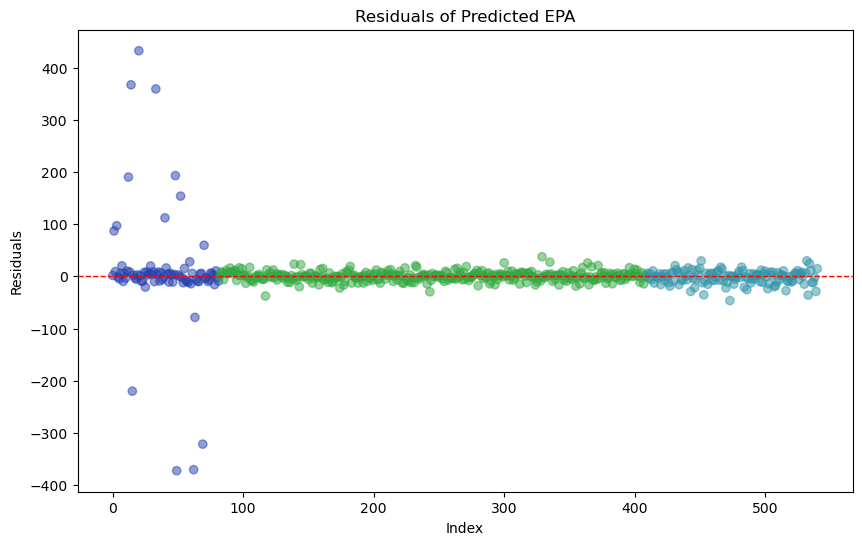

In [121]:
# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(epa_df.index, epa_df['residual'], c=epa_df['HexColor'], alpha=0.5)

# Add labels and title
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residuals of Predicted EPA')
plt.show()

For RB, TE, and WR, the residuals are relatively small in comparison to the very large residuals seen in quarterbacks. However, the residuals are still fairly large among these groups as well, despite them certainly being better than the quarterback prediction. This is evidenced by the negative or near-negative R^2 values for the training groups for quarterbacks and running backs. A model using just Madden ratings is wholly unable to predict passing or rushing EPAs with any measure of success. This furthers the idea that while Madden ratings may be effective as a rudimentary classification of player skill, they fail to capture many other factors that go into player success, and thus should not be used by NFL officials to rate potential trade targets.